<span style="font-size: 3rem; font-weight: bold;">SMD Hands-On Estimators / Fitting</span>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%matplotlib widget

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

plt.rcParams['figure.figsize'] = (7.5, 5)
plt.rcParams['figure.constrained_layout.use'] = True

In [4]:
def cov_to_corr(cov):
    '''Convert covariance to correlation matrix
    
    Taken from: https://math.stackexchange.com/a/300775/892886
    '''
    D = np.diag(1 / np.sqrt(np.diag(cov)))
    return D @ cov @ D

# Least Squares

## Analytic solution for linear combination of functions

(Analog to the exercise on the last sheet)


Here, we will fit a function of the form

$$
f(x) = p_0 + p_1 \cdot \sin(x) + p_2 \cdot \cos(x)
$$

to our data.

This function is a linear combination of basis functions:
$$
f(x) = \sum_{i=0}^2 p_i f_i(x)
$$

with

$$
f_0(x) = 1, \quad f_1(x) = \sin(x), \quad f_2(x) = \cos(x)
$$

In this case, we can use the analytic solution to the least squares optimization problem.

In [5]:
def linear_combination(x, funcs, parameters):
    '''Evaluate a linear combination of basis functions
    
    Parameters
    ----------
    x: number or np.ndarray
        The point or points at which to evaluate
    funcs: iterable of callables
        The basis functions
    parameters: iterable of numbers
        The coefficients
    '''      
    return np.sum([p * f(x) for p, f in zip(parameters, funcs, strict=True)], axis=0)

In [6]:
# define our linear model
funcs = [np.ones_like, np.sin, np.cos]

Text(0, 0.5, 'y')

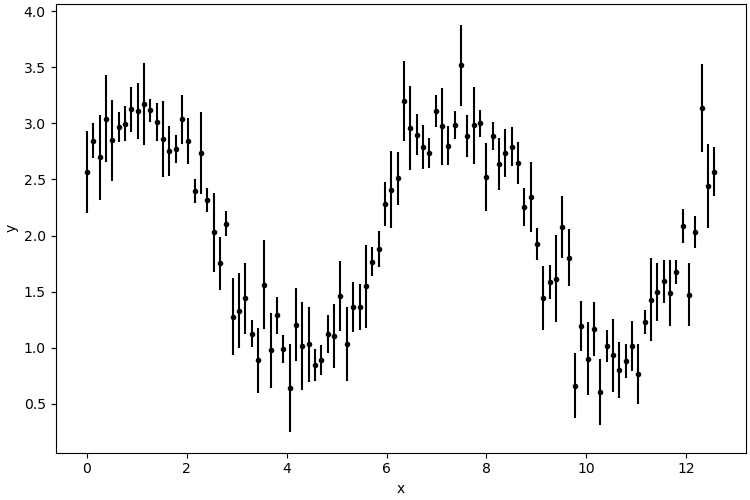

In [7]:
# create some randomized example data points
rng = np.random.default_rng(1337)

N = 100
true_parameters = np.array([2, 1, 0.5])
y_unc = rng.uniform(0.1, 0.4, N)

x = np.linspace(0, 4 * np.pi, N)
y = linear_combination(x, funcs, true_parameters)

# add some noise for to simulate measurement uncertainty
y += rng.normal(0, y_unc)

plt.figure()
plt.errorbar(x, y, yerr=y_unc, ls='', marker='.', color='k')
plt.xlabel('x')
plt.ylabel('y')

Create the design matrix $\boldsymbol{A}$

In [8]:
def design_matrix(funcs, x):
    '''Create the design matrix for a linear least squares problem'''
    return np.column_stack([f(x) for f in funcs])

In [9]:
A = design_matrix(funcs, x)
A[:5]

array([[1.        , 0.        , 1.        ],
       [1.        , 0.12659245, 0.99195481],
       [1.        , 0.25114799, 0.9679487 ],
       [1.        , 0.37166246, 0.92836793],
       [1.        , 0.48619674, 0.87384938]])

Define the weight matrix $\boldsymbol{W} = \mathrm{Cov}^{-1}(\boldsymbol{y})$ of the measurements.

Here we assume that all measured points do not have an uncertainty in $x$ and that the $y$ values are statistically independent (no off-diagonal entries in $\mathrm{Cov}(\boldsymbol{y})$).

This is a very strong assumption.

The linear least squares method yields biased results if the `Covariance` is estimated from the data points themselves. 

More on that further down in the muon example.

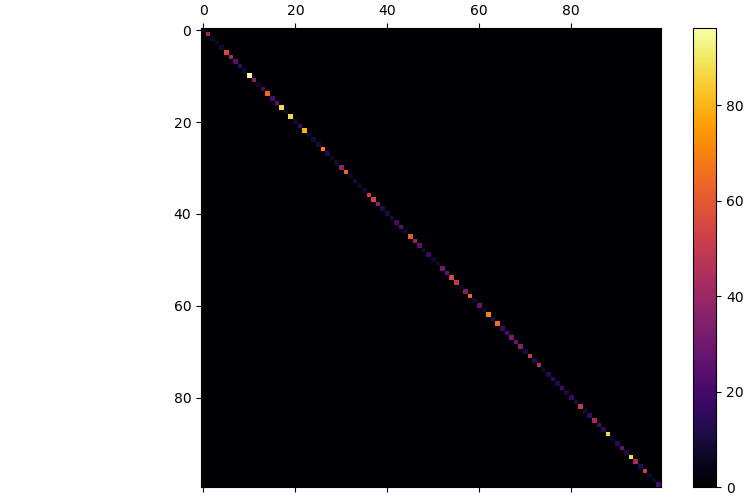

In [10]:
# All measurements have a known uncertainty and no correlations
cov_y = np.diag(y_unc**2)
               
W = np.linalg.inv(cov_y)

fig, ax = plt.subplots()
plot = ax.matshow(W)
fig.colorbar(plot)

In [11]:
W[:5, :5]

array([[ 7.571067  ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , 41.27194538,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  7.06318364,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  6.7827523 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  7.61618791]])

Solve the linear least squares problem

In [12]:
def solve_linear_least_squares(A, W, y):
    """Solve the linear least sqaures problem
    
    Parameters
    ----------
    A : np.ndarray
        Design matrix
    W : np.ndarray
        Weight matrix
    y : np.ndarray
        Vector of y values
    """
    cov = np.linalg.inv(A.T @ W @ A)
    parameters = cov @ A.T @ W @ y
    return parameters, cov


parameters, cov = solve_linear_least_squares(A, W, y)
parameters, cov

(array([2.00565538, 0.97702516, 0.48411763]),
 array([[ 3.66470863e-04, -5.58492439e-05, -1.00389068e-05],
        [-5.58492439e-05,  6.79396825e-04,  4.87671239e-05],
        [-1.00389068e-05,  4.87671239e-05,  7.92958991e-04]]))

Calculate the $\chi^2$ over the number of degrees of freedom:

In [13]:
def chisquare_over_ndf(y, A, parameters):
    residuals = (y - A @ parameters)
    sum_residuals = (residuals.T @ W @ residuals)

    ndf = len(y) - len(parameters)
    return sum_residuals / ndf


chisquare_over_ndf(y, A, parameters), chisquare_over_ndf(y, A, true_parameters)

(0.9440998449492627, 0.9551361681741547)

putting it all together:

In [14]:
def linear_least_squares(x, y, funcs, cov_y=None):
    """
    Perform a linear least squares fit.
    
    Parameters
    ----------
    x : np.ndarray[ndim=1]
        Vector of x values
    y : np.ndarray[ndim=1]
        Vector of y values
    funcs : Sequence[Callable]
        The basis functions
    cov_y : Optional[np.ndarray[ndim=2]]
        The covariance matrix of the y values
        
    Returns :
    parameters : np.ndarray[ndim=1]
        The estimated parameters
    cov : np.ndarray[ndim=2]
        Covariance matrix of the parameters
    chisq_ndf : float
        The chisquare over the number of degrees of freedom
        of the fit result.
    """
    A = design_matrix(funcs, x)
    
    if cov_y is not None:
        W = np.linalg.inv(cov_y)
    else:
        W = np.eye(len(y))
    
    parameters, cov = solve_linear_least_squares(A, W, y)
    
    chisquare_ndf = chisquare_over_ndf(y, A, parameters)
    
    return parameters, cov, chisquare_ndf

Result:

In [15]:
parameters, cov, chisquare_ndf = linear_least_squares(x, y, funcs, cov_y)

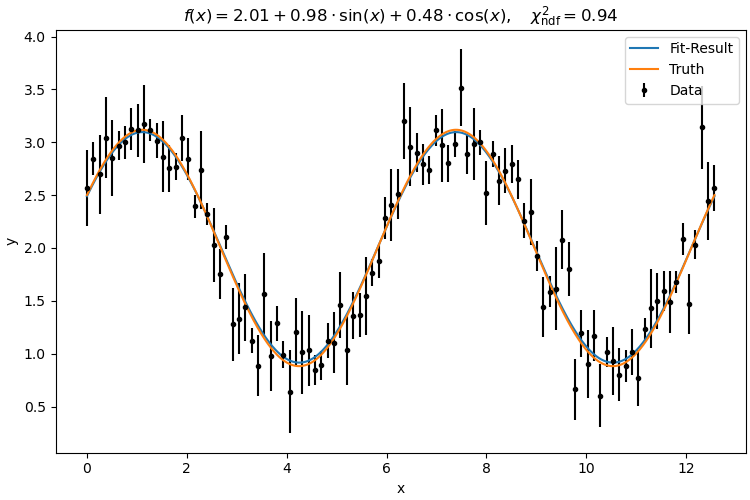

In [16]:
x_fit = np.linspace(0, 4 * np.pi, 1000)
y_fit = linear_combination(x_fit, funcs, parameters)
y_truth = linear_combination(x_fit, funcs, true_parameters)


fig, ax = plt.subplots()

ax.errorbar(x, y, yerr=y_unc, ls='', marker='.', label='Data', color='k')

ax.plot(x_fit, y_fit, label='Fit-Result')
ax.plot(x_fit, y_truth, label='Truth')

ax.set(
    title=(
        rf'$f(x) = {parameters[0]:.2f} + {parameters[1]:.2f} \cdot \sin(x) + {parameters[2]:.2f} \cdot \cos(x)'
        rf', \quad \chi^2_\mathrm{{ndf}} = {chisquare_ndf:.2f}$'
    ),
    xlabel='x',
    ylabel='y',
)


ax.legend()

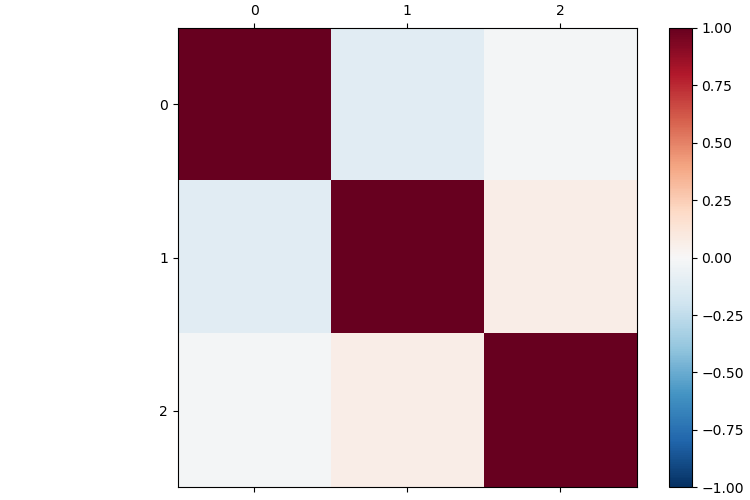

In [17]:
corr = cov_to_corr(cov)

fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(1, 1, 1)
m = ax.matshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)
fig.colorbar(m)

## Numerical solution for non-linear functions


If the function is not a linear combination of basis functions, the solution
can only be found numerically.

From the lab courses, you probably know the `scipy.optimize.curve_fit` function, which does exactly this.

The Nelder-Mead-Algorithm use by `curve_fit` has the nice property that it is guaranteed to find the analytical
solution, if it exists.


- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

### Example application to our linear problem

In [18]:
from scipy.optimize import curve_fit


def func(x, p1, p2, p3):
    return p1 + p2 * np.sin(x) + p3 * np.cos(x)


# absolute_sigma prevents scaling of errors to match χ²/ndf=1
parameters_numeric, cov_numeric = curve_fit(
    func,x, y,
    sigma=np.full(N, y_unc),
    absolute_sigma=True,
)

print(parameters, parameters_numeric, cov, cov_numeric, sep='\n')

[2.00565538 0.97702516 0.48411763]
[2.00565538 0.97702516 0.48411763]
[[ 3.66470863e-04 -5.58492439e-05 -1.00389068e-05]
 [-5.58492439e-05  6.79396825e-04  4.87671239e-05]
 [-1.00389068e-05  4.87671239e-05  7.92958991e-04]]
[[ 3.66470864e-04 -5.58492456e-05 -1.00389063e-05]
 [-5.58492456e-05  6.79396817e-04  4.87671204e-05]
 [-1.00389063e-05  4.87671204e-05  7.92958981e-04]]


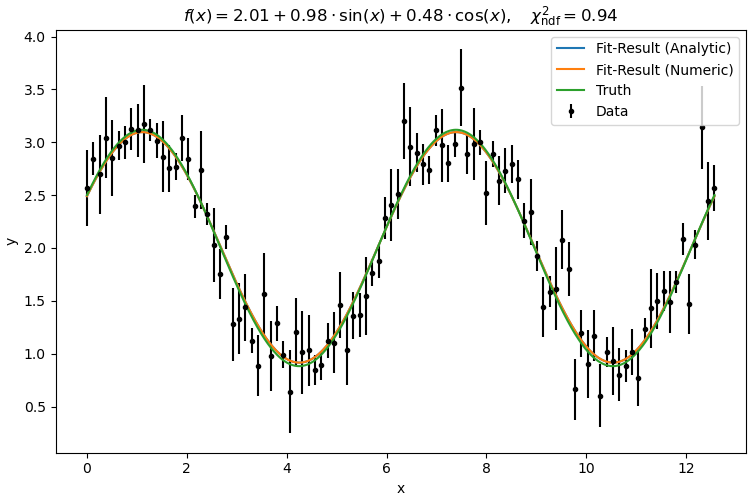

In [19]:
x_fit = np.linspace(0, 4 * np.pi, 1000)
y_fit = func(x_fit, *parameters)
y_num = func(x_fit, *parameters_numeric)
y_truth = func(x_fit, *true_parameters)
 

fig, ax = plt.subplots()

ax.errorbar(x, y, yerr=y_unc, ls='', marker='.', label='Data', color='k')

ax.plot(x_fit, y_fit, label='Fit-Result (Analytic)')
ax.plot(x_fit, y_num, label='Fit-Result (Numeric)')
ax.plot(x_fit, y_truth, label='Truth')

ax.set(
    title=(
        rf'$f(x) = {parameters[0]:.2f} + {parameters[1]:.2f} \cdot \sin(x) + {parameters[2]:.2f} \cdot \cos(x)'
        rf', \quad \chi^2_\mathrm{{ndf}} = {chisquare_ndf:.2f}$'
    ),
    xlabel='x',
    ylabel='y',
)


ax.legend()

### Why not simply always chose the numerical solution then?

In [20]:
%%timeit
linear_least_squares(x, y, funcs)

131 µs ± 8.56 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [21]:
%%timeit
curve_fit(func, x, y)

126 µs ± 327 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Example with non-linear function 


From the lab courses: single slit diffraction

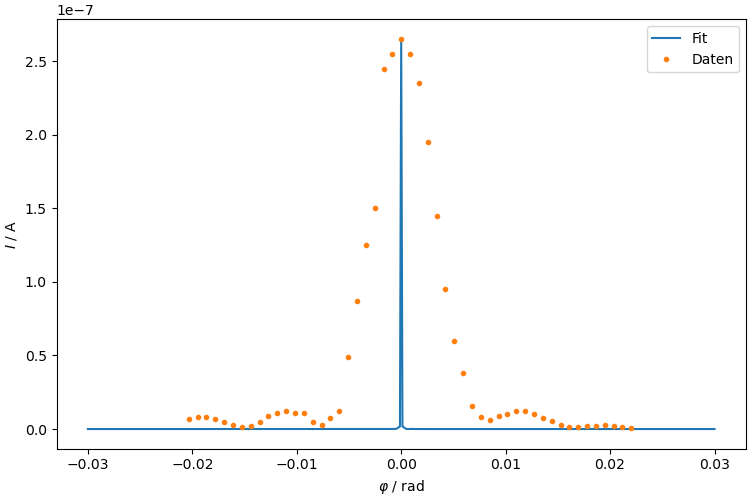

In [22]:
df = pd.read_csv('resources/spalt.csv')


LASER_WAVELENGTH_NM = 632.8e-9

def theory(phi, A0, b):
    return (A0 * b * np.sinc(b * np.sin(phi) / LASER_WAVELENGTH_NM))**2


# first try with default initial guess (1 for every parameter)
p0 = None

# now with an "educated guess" based on the data and knowledge of the
# order of magnitude of the slit size
# p0 = [np.sqrt(df['I'].max()) / 1e-4, 1e-4]

params, cov = curve_fit(theory, df['phi'], df['I'], p0=p0)


x = np.linspace(-0.03, 0.03, 501)

fig, ax = plt.subplots()
ax.plot(x, theory(x, *params), label='Fit')

ax.plot(df['phi'], df['I'], '.', label='Daten')

ax.set(
    xlabel=r'$\varphi \,\, / \,\, \mathrm{rad}$',
    ylabel=r'$I \,\, / \,\, \mathrm{A}$',
)
ax.legend(loc='best')

None # to not have mpl objects in the output

# Maximimum-Likelihood-Method


## Unbinned Fit of Probability Densities

Strongly simplified example of a CERN-Like analysis.


We are looking for the mass-peak of a (normally distributed) particle.

We also observed a background, which in this simplified example is assumed to be exponentially distributed.

We create a simple "Toy"-Dataset using Monte Carlo methods:

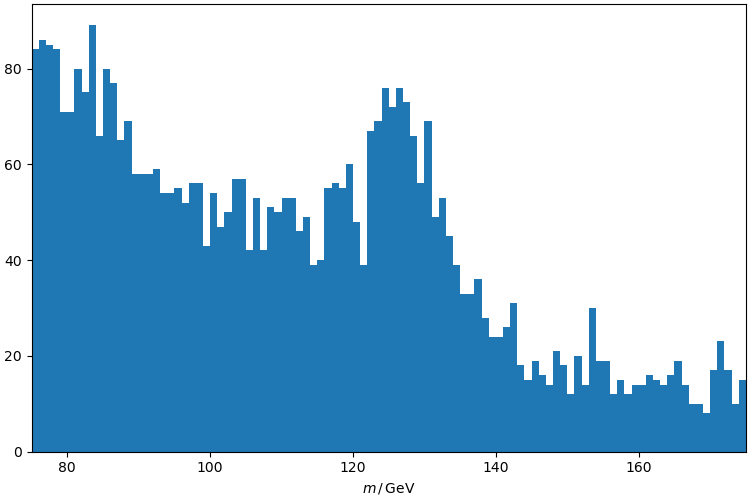

In [23]:
rng = np.random.default_rng(42)

E_MIN = 75
E_MAX = 175

# normally distributed signal
higgs_signal = np.random.normal(126, 5, 500)

# exponentially distributed background
background = np.random.exponential(50, size=20000)

# combine signal and background
measured = np.append(higgs_signal, background)

# remove events outside of "detector range"
in_range = (E_MIN <= measured) & (measured <= E_MAX)
measured = measured[in_range]


fig, ax = plt.subplots()
ax.hist(measured, bins=100)
ax.set_xlabel('$m \,/\, \mathrm{GeV}$')
ax.margins(x=0)
None

### Definition of the negative Log-Likelihood

We create a superposition of two probability densities, each with a proportion of $p$ and $1 - p$ respectively.


We also need to normalize the densities to the observed interval.

In this special case, we ignore this for the normal distribution, assuming that it is fully contained in the measurement interval.

So:

\begin{align}
P_1 &= N(\mu, \sigma) \\[1ex]
P_2 &= \frac{1}{\exp(-E_\mathrm{min} / \tau) - \exp(-E_\mathrm{max} / \tau)} \exp(- E / \tau) \\[1ex]
P(E | p, \mu, \sigma, \tau) &= p \cdot P_1(E, \mu, \sigma) + (1 - p) P_2(E | \tau)) \\[1ex]
\mathcal{L}(p, \mu, \sigma, \tau) &= \prod_i P(E_i | p, \mu, \sigma, \tau) \\[1ex]
-\log\mathcal{L}(p, \mu, \sigma, \tau) &= -\sum_i \log(P(E_i | p, \mu, \sigma, \tau))
\end{align}

In code, using the distribution classes from `scipy.stats`, it looks like this:

In [24]:
from scipy.stats import norm, expon


def pdf(x, mean, std, tau, p):
    mass_peak = p * norm.pdf(x, mean, std)
    
    expon_norm = np.exp(-E_MIN / tau) - np.exp(-E_MAX / tau)
    background = (1 - p)  / expon_norm * expon.pdf(x, scale=tau)
    
    return mass_peak + background

### Solution using `scipy.optimize.minimize` und `numdifftools.Hessian`


Using `scipy.optimize.minimize`, we can minimize arbitrary functions.


The functions need to have an array of the fit parameters as first argument.

Further arguments can be passed using the `args` argument of `minimize`.


Naïvely, our negative Log-Likelihood for use with scipy looks like this:

In [25]:
def neg_log_likelihood(parameters, data):
    # we add an epsilon to avoid inf in case of p=0
    return -np.sum(np.log(pdf(data, *parameters) + 1e-30))

Naïve, because often, analytic simplifications of the log-likelihood are possible!

Analytic simplifications both benefit numerical precision and evaluation speed.

It is almost always a good idea, to write down the likelihood on paper and simplify analytically as far as possible.

We find a minimum (and hopefully the global one) using `scipy.optimize.minimize`. 

As known from the previous lecture, we can estimate the covariance matrix of the parameters from the inverse of the Hessian matrix of the negative log-likelihood,
evaluated at the found minimum.


The Hessian matrix needs to be determined numerically.
`scipy.optimize.minimize` returns a rough estimate, but this is borderline unusable.


We use `numdifftools.Hessian` to get the Hessian numerically.


`scipy.optimize.minimize` can use multiple algorithms each with benefits and drawbacks under the hood.
For more information, see
 
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
* https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html

In [26]:
from scipy.optimize import minimize

# a very small number to achive > 0 instead of >= 0
eps = np.finfo(np.float64).eps

result = minimize(
    neg_log_likelihood,
    args=(measured, ),
    x0=[130, 2, 30, 0.2], # here, the initial guess is required
    bounds=[
        (0, None),    # mean >= 0
        (eps, None),  # std > 0
        (eps, None),  # tau > 0
        (0, 1),       # 0 <= p <= 1
    ],
)

result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 19327.321825404608
        x: [ 1.264e+02  5.742e+00  4.986e+01  1.314e-01]
      nit: 23
      jac: [ 0.000e+00 -1.455e-03  0.000e+00  2.725e-01]
     nfev: 175
     njev: 35
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [27]:
from numdifftools import Hessian

hesse = Hessian(neg_log_likelihood)
cov = np.linalg.inv(hesse(result.x, measured))

In [28]:
higgs_mass = result.x[0]
higgs_mass_unc = np.sqrt(cov[0, 0])


print(f'Higgs mass is {higgs_mass:.2f} ± {higgs_mass_unc:.2} GeV')

Higgs mass is 126.37 ± 0.48 GeV


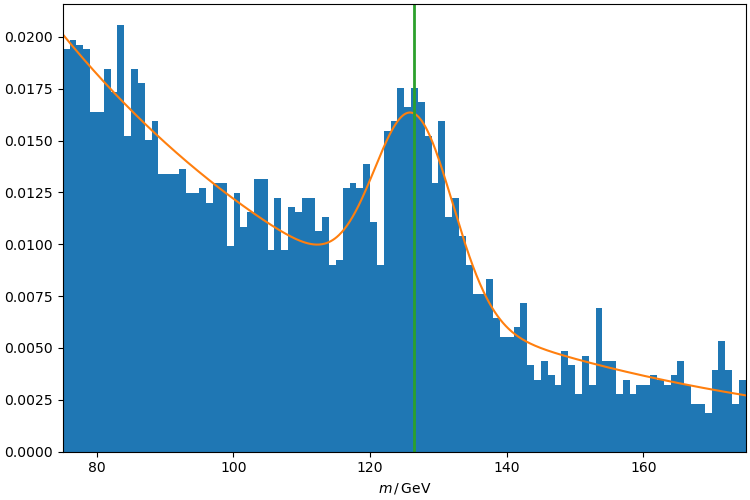

In [29]:

e = np.linspace(E_MIN, E_MAX, 1000)


fig, ax = plt.subplots()

ax.hist(measured, bins=100, density=True)
ax.plot(e, pdf(e, *result.x))
ax.axvline(result.x[0], color='C2', lw=2)

ax.set_xlabel('$m \,/\, \mathrm{GeV}$')
ax.margins(x=0)

### Solution using iminuit


Iminuit provides python bindings for the `Minuit` minimization package from the `ROOT` framework.

It does not require a full `ROOT` installation.

"Minuit" is held to be – at least among particle physisicists – as non-plus-ultra of mimimizers.


`iminuit` provides the minimizers and several helper classes for loss functions.
This makes it much simpler to perform fits.


It can also use likelihood ratio tests via the `minos` interface to estimate parameter uncertainties.
(More on that in the next lectures). 




For starters, let's solve the same problem as above, this time using `iminuit`:

In [30]:
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL

# minuit's UnbinnedNLL takes directly the pdf and the observed data
loss = UnbinnedNLL(measured, pdf)

m = Minuit(loss, mean=130, std=2, tau=30, p=0.2)

# set bounds
m.limits['mean'] = (0, None)   # >= 0
m.limits['std'] = (eps, None)  # > 0
m.limits['tau'] = (eps, None)  # > 0
m.limits['p'] = (0, 1)

# perform minimization
m.migrad()

# perform likelihood scan for confidence intervals
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.865e+04                  │              Nfcn = 385              │
│ EDM = 1.05e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean │   126.4   │    0.5    │    -0.5    │    0.5     │    0    │         │       │
│ 1 │ std  │    5.7    │    0.5    │    -0.5    │    0.6     │2.22045e-16│         │       │
│ 2 │ tau  │   49.9    │    1.7    │    -1.6    │    1.7     │2.22045e-16│         │       │
│ 3 │ p    │   0.131   │   0.011   │   -0.011   │   0.011    │    0    │    1    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │         mean          │          std          │          tau          │           p           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.5    │    0.5    │   -0.5    │    0.6    │   -1.6    │    1.7    │  -0.011   │   0.011   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌──────┬─────────────────────────────────────┐
│      │     mean      std      tau        p │
├──────┼─────────────────────────────────────┤
│ mean │    0.232    -0.07    -0.02 -1.06e-3 │
│  std │    -0.07    0.286    -0.21  3.56e-3 │
│  tau │    -0.02    -0.21     2.82 -6.08e-3 │
│    p │ -1.06e-3  3.56e-3 -6.08e-3 0.000121 │
└──────┴─────────────────────────────────────┘

In [31]:
higgs_mass = m.values['mean']
higgs_mass_unc = m.errors['mean']

print(f'Higgs mass is {higgs_mass:.2f} ± {higgs_mass_unc:.2} GeV')

Higgs mass is 126.37 ± 0.48 GeV


## Poisson-Likelihood-Fit using a binned Event Distribution

If the single observations are not accessible or the runtime of the analysis is critical for large amounts of data,
a so-called "binned" fit is also possible.

In a binned fit, we estimate the parameters of the distributions from a histogram.


Since a histogram is a counting experiment, the single event numbers in each bin each follow a Poisson distribution.


The cumulative probability function yields together with the total number of observed events the expected value in each histogram bin,
dependent on the fit parameters $\boldsymbol{\theta}$.

$$
\mathcal{L} = \prod_{i=1}^N \mathcal{P}(k=H_i, \lambda=\lambda_i(\boldsymbol{\theta}))
$$

with 

$$
\lambda_i = N_\mathrm{total} \cdot (\mathrm{CDF}(b_i, \boldsymbol{\theta}) - \mathrm{CDF}(a_i, \boldsymbol{\theta}))
$$

Here, $a_i$ und $b_i$ are the bin edges of the $i$-th bin.
We then integrate the PDF in each bin and multiply with the total number of events.


### Example from "Lifetime of cosmic Muons" (Lab Course Experiment V01)

The experimental setup of this lab course experiment directly produces a histogram of observed decay times in hardware.

We thus cannot perform an unbinned fit, the single values are simply not available.

The lab course instruction ask for a least squares fit to the bin heights.

This method yields an unbiased estimator but with non-optimal spread, as long as an unweighted fit is performed.

In the past, it was recommended to perform a weighted fit assuming $\sigma_i = \sqrt{H_i}$.

This is wrong! This method consistently yields biased results, due to  under-fluctuations being weighted more strongly than over-fluctuations of the same amount.

The correct method is the binned Poisson-likelihood fit as discussed here or the iterative least squares method discussed in SMD-2.

A comparison of the different methods is available here: https://gist.github.com/maxnoe/41730e6ca1fac01fc06f0feab5c3566d

In the experiment, there is an additional uniformly distributed background from non-decaying, coincident muons.

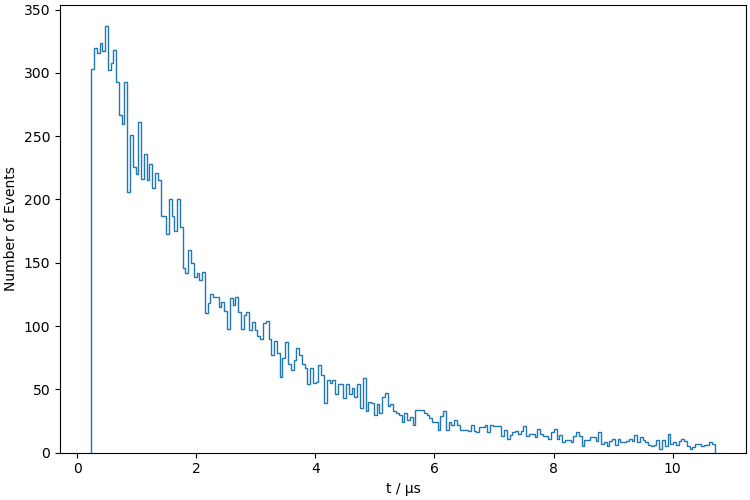

In [32]:
N = np.genfromtxt("resources/muon_data.txt")
t = np.arange(len(N) + 1) / 21.48

t = t[5:]
N = N[5:]

plt.figure()
plt.stairs(values=N, edges=t)
plt.xlabel('t / µs')
plt.ylabel('Number of Events')
None

`Iminuit` provides the `BinnedNLL` loss function for this use cases.

In [33]:
from iminuit.cost import BinnedNLL
from scipy.stats import uniform

T_MIN, T_MAX = t[0], t[-1]

def cdf(x, tau, p):
    # normalize to 1 in histogram range
    cdf_min, cdf_max = expon.cdf([T_MIN, T_MAX], scale=tau) 
    norm = 1 / (cdf_max - cdf_min)
    
    signal = p * expon.cdf(x, scale=tau) * norm
    background = (1 - p) * uniform.cdf(x, T_MIN, T_MAX)
    # combine exponential signal with uniform background
    return signal + background


# histogram counds, histogram edges and cumulative distribution function
loss = BinnedNLL(N, t, cdf)

m = Minuit(loss, tau=2, p=0.99)
m.limits['tau'] = (eps, None)
m.limits['p'] = (0, 1)
m.migrad()
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 247.5 (χ²/ndof = 1.1)      │              Nfcn = 103              │
│ EDM = 1.62e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau  │   2.169   │   0.034   │   -0.034   │   0.035    │2.22045e-16│         │       │
│ 1 │ p    │   0.958   │   0.007   │   -0.007   │   0.007    │    0    │    1    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │          tau          │           p           │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.034   │   0.035   │  -0.007   │   0.007   │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌─────┬───────────────────┐
│     │      tau        p │
├─────┼───────────────────┤
│ tau │  0.00119  0.20e-3 │
│   p │  0.20e-3 5.47e-05 │
└─────┴───────────────────┘

In [34]:
muon_lifetime = m.values['tau']
muon_lifetime_unc = m.errors['tau']
pdg_reference = 2.1969811
pdg_reference_unc = 0.0000022

print(f'Fit: τ = {muon_lifetime:.3f} ± {muon_lifetime_unc:.3f} µs')
print(f'Lit: τ = {pdg_reference:.7f} ± {pdg_reference_unc:.7f} µs')

Fit: τ = 2.169 ± 0.034 µs
Lit: τ = 2.1969811 ± 0.0000022 µs


Likelihood-Scan for uncertainty intervals:

In [35]:
tau, ts, valid = m.mnprofile('tau', size=100)

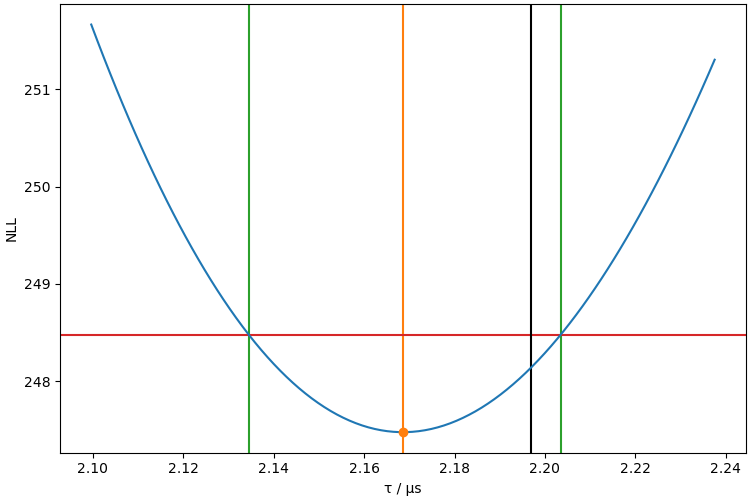

In [36]:
plt.figure()

plt.axvline(m.values['tau'], color='C1')
plt.plot(m.values['tau'], m.fval, color='C1', marker='o', zorder=3)

plt.axvline(m.values['tau'] + m.merrors['tau'].lower, color='C2')
plt.axvline(m.values['tau'] + m.merrors['tau'].upper, color='C2')
plt.axhline(m.fval + 1, color='C3')
plt.axvline(pdg_reference, color='k', label='PDG')
plt.plot(tau, ts)

plt.xlabel('τ / µs')
plt.ylabel('NLL')
None

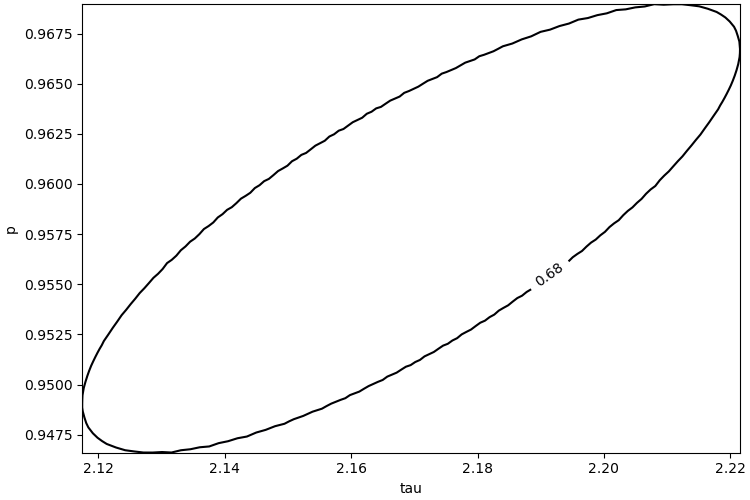

In [37]:
plt.figure()
m.draw_mncontour('tau', 'p', size=250)